# overview

Goal: verify basic statistics over the consumed customer issue dataset.

Conclusions reached:
* State seems uncorrelated with the all other features (including the issue type)
* The issue type is strongly correlated with the issue itself being disputed or not,
  as well as the type of the product in question

Expected facts verified:
* Product is strongly correlated with the issue type
* An issue being timely responded correlated with its resolution

In [2]:
import numpy as np
import pandas as pd

from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import dextra.dna.core as C
import dextra.dna.commons as P

Using local environment.


In [4]:
spark = P.config.spark

pd.set_option('display.max_colwidth', 200)

sns.set()

## Reading Trusted Dataset

In [5]:
DATA_FILE = P.config.lakes.refined + '/issues.parquet'

In [6]:
x = C.io.stream.read(DATA_FILE)

x.limit(5).toPandas()

,complaint_id,consumer_message,customer_name,date_received,disputed,issue,product,resolution,state,sub_issue,sub_product,tags,timely_response,via,zip_code,ingested_at
0,fbf77b8d5880,3463 Averst Bank 2008 this is to old to be on my credit repot. Its 4985. I want this removed. I gave this back to then. They sold me a lemon. The transmission had went out of this thing after a 44...,ecbc39add660,2017-01-16,False,Cont'd attempts collect debt not owed,Debt collection,Closed with explanation,960999033556,Debt was paid,Auto,None,True,Web,73123,2020-12-03 20:01:53.662609
1,fbf7e0affa38,"My loan was sold to Nationstar. At the time there was a {$1400.00} escrow surplus. However after one month, NS sent a letter stating that an audit revealed I had a shortage of {$500.00} and my pym...",dd0bf53c5982,2015-09-02,True,"Loan servicing, payments, escrow account",Mortgage,Closed with explanation,577ce5eff01b,None,Conventional fixed mortgage,None,True,Web,91113,2020-12-03 20:01:53.662609
2,fbf7fda793c5,Dear Sir or Madam : I am writing to file a complaint against USAA following their handling of a dispute of a billing error in the amount of {$1300.00} 0662 on my USAA {phone} account. The amount i...,8c6ba4882fdb,2015-09-09,False,Billing disputes,Credit card,Closed with explanation,86266b7866cc,None,None,Servicemember,True,Web,10064,2020-12-03 20:01:53.662609
3,fbf80c5bdf5f,"PLEASE FIND ATTACHED LETTER I WROTE TO THE MORTGAGE COMPANY THAT I USED TO BE WITH AND PAY PAYMENTS. THEY ARE REPORTING LATE PAYMENT, I WAS 8556 TO 6951 BACK THEN AND MY PARENTS MADE A MISTAKE AN...",9d59e25a9a81,2017-08-30,None,Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,577ce5eff01b,Account status incorrect,Credit reporting,Servicemember,True,Web,91687,2020-12-03 20:01:53.662609
4,fbf897be7d3d,Merchants Credit continues to report 8030 paid medical accounts that were the result of a billing error despite my written letters and being notified in writing by original creditor ( 9160 97...,ba5bdf5ece97,2017-05-22,None,Attempts to collect debt not owed,Debt collection,Untimely response,b621dda48fda,Debt was paid,Medical debt,None,False,Web,98095,2020-12-03 20:01:53.662609


## Overview

In [7]:
print('Samples:', x.count())
print('Users:', x.select('customer_name').distinct().count())
print('Users with a single complaint:', x.groupBy('customer_name').count().where(F.col('count') == 1).count())
print(f'Rate: {86038 / 119805:.1%}')

Samples: 199970
Users: 119805
Users with a single complaint: 86038
Rate: 71.8%


### General Appareant Relationships

In [8]:
corr, p = C.analysis.correlation.correlation_matrix(
    x.select('state via resolution disputed timely_response product issue'.split()))

/opt/conda/lib/python3.8/site-packages/dextra/dna/core/analysis/correlation.py:89: ChiSquareSmallFrequencyWarning: Some of the observed frequencies are less than 5, the Chi-Squared test may not be valid. See https://en.wikipedia.org/wiki/Pearson's_chi-squared_test#Problems for more information.
  warnings.warn("Some of the observed frequencies are less than 5, the Chi-Squared test may not be valid. "
/opt/conda/lib/python3.8/site-packages/dextra/dna/core/analysis/correlation.py:96: ChiSquareSmallFrequencyWarning: Some of the expected frequencies are less than 5, a likelihood ratio-based test statistic may be better fit for this sample. Consider setting how="likelihood". See https://en.wikipedia.org/wiki/Pearson's_chi-squared_test#Problems for more information.
  warnings.warn("Some of the expected frequencies are less than 5, a likelihood ratio-based test statistic "
/opt/conda/lib/python3.8/site-packages/dextra/dna/core/analysis/correlation.py:106: CategoricalCorrelationSingleClassWar

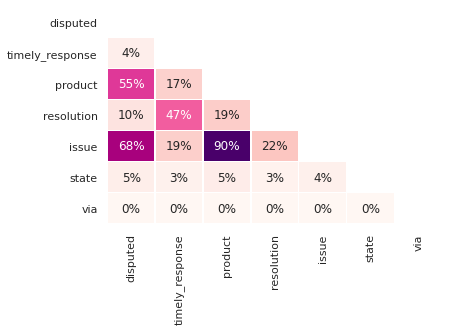

In [9]:
mk = (p >= 0.05).values
mk[np.triu_indices_from(mk)] = True

with sns.axes_style('white'):
    sns.heatmap(corr, mask=mk, fmt='.0%', annot=True, cbar=False, linewidths=.5, cmap='RdPu');

### 